<a href="https://colab.research.google.com/github/habstrakT808/Simple-Cashier-Application-with-GUI-JAVA/blob/main/Project_Akhir_Deep_Learning_Hafiyan_Al_Muqaffi_Umary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT AKHIR DEEP LEARNING**

### **Deteksi Serangan Man-in-the-Middle (MitM) pada Jaringan Menggunakan Dataset: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv dan Library: PyTorch**

### **Ringkasan Tujuan Utama:**

Mahasiswa melakukan penelitian sederhana dan singkat pada domain keamanan siber dengan memanfaatkan pendekatan deep learning.

###**Pipeline ini dirancang untuk:**###
1. Membersihkan dan menyiapkan data dari file dataset.
2. Melatih model LSTM untuk mendeteksi serangan MitM.
3. Mengevaluasi performa model secara menyeluruh.
4. Menyediakan visualisasi untuk membantu interpretasi hasil.

### **Dataset:**
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Paling relevan karena serangan infiltrasi memiliki pola lalu lintas jaringan yang mirip dengan MitM.

Downloadlah data dari link berikut: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset

### 1. Setup dan Import Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

**Penjelasan:**
- Langkah ini digunakan untuk mengimpor library yang dibutuhkan dalam proyek.
- **Tujuan:**
  - `pandas`, `numpy`: Untuk manipulasi data.
  - `torch`, `torch.nn`, `torch.optim`: Untuk membangun dan melatih model LSTM.
  - `sklearn`: Untuk preprocessing data dan evaluasi.
  - `matplotlib`, `seaborn`: Untuk visualisasi hasil.
---

### 2. Fungsi untuk Load Dataset

In [ ]:
def load_dataset(file_path):
    """
    Memuat dataset dari file CSV dan menampilkan beberapa statistik dasar.
    Args:
        file_path (str): Path ke file dataset.
    Returns:
        pd.DataFrame: Dataframe dengan data yang dimuat.
    """
    data = pd.read_csv(file_path)
    print(f"Dataset Shape: {data.shape}")
    print(data.head())
    return data

**Penjelasan:**
- Fungsi `load_dataset()` digunakan untuk membaca file dataset dalam format CSV dan menampilkan statistik awal (seperti jumlah kolom, baris, dan cuplikan data).
- **Tujuan:** Memastikan bahwa dataset berhasil dimuat ke dalam program, memvalidasi struktur dataset, dan mempermudah eksplorasi awal.

---

### 3. Preprocessing Dataset

In [ ]:
def preprocess_data(data):
    """
    Membersihkan dan memproses dataset.
    Args:
        data (pd.DataFrame): Dataframe input.
    Returns:
        X (np.array): Fitur yang sudah dinormalisasi.
        y (np.array): Label yang sudah dienkode.
    """
    # Drop kolom yang tidak relevan (jika ada)
    drop_columns = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']  # Sesuaikan jika ada
    data = data.drop(columns=[col for col in drop_columns if col in data.columns], errors='ignore')

    # Tangani nilai NaN dan Inf
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # Pisahkan fitur dan label
    X = data.drop(' Label', axis=1)
    y = data[' Label']

    # Normalisasi fitur
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Encode label
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    return X, y, encoder.classes_

**Penjelasan:**
- Langkah ini membersihkan data dengan:
  1. Menghapus kolom yang tidak relevan (misalnya `Flow ID`, `Source IP`).
  2. Menangani nilai `NaN` atau `Inf` agar tidak mengganggu model.
  3. Memisahkan fitur (`X`) dan label (`y`).
  4. Normalisasi (`StandardScaler`) untuk memastikan semua fitur memiliki skala yang sama.
  5. Mengubah label menjadi format numerik (`LabelEncoder`).
- **Tujuan:** Menghasilkan dataset yang bersih, konsisten, dan siap untuk digunakan dalam pelatihan model.

---

### 4. Dataset Custom PyTorch

In [ ]:
class NetworkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

**Penjelasan:**
- `NetworkDataset` adalah kelas khusus PyTorch untuk mengelola dataset. Ini mengonversi `X` (fitur) dan `y` (label) menjadi tensor yang kompatibel dengan PyTorch.
- **Tujuan:** Memastikan data dapat diakses oleh DataLoader PyTorch dalam bentuk batch, sehingga efisien untuk pelatihan.

---

### 5. Model LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

**Penjelasan:**
- `LSTMModel` adalah model berbasis LSTM yang dirancang untuk memproses data sekuensial.
- Komponen utama:
  1. **LSTM Layer:** Memproses data sekuensial dan menangkap pola temporal.
  2. **Linear Layer:** Mengubah keluaran LSTM menjadi prediksi label akhir.
- **Tujuan:** Membangun arsitektur model untuk mendeteksi serangan MitM.

---

### 6. Training dan Evaluasi

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    """
    Melatih model LSTM.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, test_loader):
    """
    Mengevaluasi model LSTM.
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.unsqueeze(1))
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    print(classification_report(y_true, y_pred))
    return y_true, y_pred

#### a. `train_model()`
**Penjelasan:**
- Fungsi ini melatih model menggunakan *training data*.
- Komponen utama:
  1. *Forward pass:* Data melewati model untuk menghasilkan prediksi.
  2. *Backward pass:* Menghitung dan memperbarui bobot berdasarkan *loss*.
- **Tujuan:** Melatih model untuk mempelajari pola dari data.

---

#### b. `evaluate_model()`
**Penjelasan:**
- Fungsi ini mengevaluasi kinerja model pada *test data*.
- Komponen utama:
  - Membandingkan prediksi dengan label sebenarnya.
  - Menghasilkan laporan klasifikasi (presisi, recall, F1-score).
- **Tujuan:** Mengukur efektivitas model dalam mendeteksi serangan MitM.

---

### 7. Visualisasi Hasil

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Membuat plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**Penjelasan:**
- `plot_confusion_matrix()` membuat *confusion matrix* yang menggambarkan prediksi benar dan salah dari model.
- **Tujuan:** Memberikan gambaran visual tentang performa model, termasuk jenis kesalahan prediksi.

---

### 8. Pipeline Utama

In [ ]:
# File dataset
dataset_path = '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv'

# Langkah 1: Load Dataset
data = load_dataset(dataset_path)

# Langkah 2: Preprocessing
X, y, class_names = preprocess_data(data)

# Langkah 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Langkah 4: Buat Dataloader
train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Langkah 5: Inisialisasi Model
input_dim = X.shape[1]
hidden_dim = 128
output_dim = len(class_names)
model = LSTMModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Langkah 6: Training
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Langkah 7: Evaluasi
y_true, y_pred = evaluate_model(model, test_loader)

Dataset Shape: (288602, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0                 22             166                   1   
1              60148              83                   1   
2                123           99947                   1   
3                123           37017                   1   
4                  0       111161336                 147   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            0   
1                        2                            0   
2                        1                           48   
3                        1                           48   
4                        0                            0   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       0   
1                             0                       0   
2                            48                      48   
3                   

In [ ]:
data[' Label'].value_counts()

,count
Label,
BENIGN,288566
Infiltration,36


### **Penjelasan Kode**

#### a. **Langkah 1: Load Dataset**
- **Penjelasan:** Memuat file dataset ke dalam program menggunakan `load_dataset()`.
- **Tujuan:** Memastikan data tersedia untuk langkah berikutnya.

---

#### b. **Langkah 2: Preprocessing**
- **Penjelasan:** Membersihkan dan memproses dataset menggunakan `preprocess_data()`.
- **Tujuan:** Menyiapkan data dalam format yang sesuai untuk pelatihan model.

---

#### c. **Langkah 3: Split Data**
- **Penjelasan:** Memisahkan data menjadi *training set* dan *test set* menggunakan `train_test_split()`.
- **Tujuan:** Melatih model pada data tertentu dan menguji performanya pada data lainnya.

---

#### d. **Langkah 4: Buat Dataloader**
- **Penjelasan:** Membuat `DataLoader` untuk mengelola data secara batch.
- **Tujuan:** Mempermudah pengelolaan data dalam batch selama pelatihan.

---

#### e. **Langkah 5: Inisialisasi Model**
- **Penjelasan:** Menginisialisasi model LSTM, *loss function*, dan optimizer.
- **Tujuan:** Menyiapkan komponen utama untuk pelatihan model.

---

#### f. **Langkah 6: Training**
- **Penjelasan:** Melatih model menggunakan `train_model()`.
- **Tujuan:** Membantu model mempelajari pola dalam data.

---

#### g. **Langkah 7: Evaluasi**
- **Penjelasan:** Mengevaluasi performa model menggunakan `evaluate_model()`.
- **Tujuan:** Memastikan model dapat mendeteksi serangan secara akurat.

---

### **Penjelasan Output**

#### **1. Dataset Shape**
- **`Dataset Shape: (288602, 79)`**
  - Dataset memiliki **288.602 baris** dan **79 kolom**.
  - Baris menunjukkan jumlah sampel dalam dataset.
  - Kolom berisi fitur-fitur jaringan yang digunakan untuk deteksi serangan, termasuk fitur seperti *Destination Port*, *Flow Duration*, dan label (*Label*).

#### **2. Head Dataset**
Bagian ini menampilkan **5 baris pertama dataset** untuk memberikan gambaran isi dataset. Berikut penjelasan beberapa kolom:
- **`Destination Port`**: Port tujuan untuk koneksi jaringan.
- **`Flow Duration`**: Durasi aliran data (dalam mikrodetik).
- **`Total Fwd Packets` & `Total Backward Packets`**: Jumlah paket yang dikirim maju/mundur.
- **`Label`**: Label untuk setiap sampel; *BENIGN* menunjukkan aktivitas normal, sedangkan serangan memiliki label spesifik.

Dataset ini juga menunjukkan adanya fitur numerik yang perlu distandarisasi sebelum digunakan dalam model.

---

#### **3. Proses Training**
Output *training* menunjukkan bagaimana model LSTM belajar selama **10 epoch**:
- **`Epoch 1/10, Loss: 0.007095001886827126`**  
  - Pada awal pelatihan, loss cukup besar (sekitar 0.007). Ini menunjukkan bahwa model belum sepenuhnya memahami data.
- **`Epoch 10/10, Loss: 0.0002348506303614888`**  
  - Setelah 10 epoch, loss menurun menjadi sangat kecil (0.00023). Penurunan ini menunjukkan bahwa model telah belajar dengan baik dari data pelatihan.

#### **4. Evaluasi Model**
Evaluasi model dilakukan menggunakan metrik seperti *precision*, *recall*, *f1-score*, dan *accuracy*. Berikut detailnya:

##### **a. Klasifikasi Berdasarkan Label**
Dataset memiliki dua kelas:
- **Kelas 0**: Aktivitas normal (*BENIGN*).
- **Kelas 1**: Serangan *Infiltration*.

##### **b. Performansi Klasifikasi**
- **Precision**: Proporsi prediksi positif yang benar.
  - **Kelas 0**: 1.00 (semua prediksi aktivitas normal benar).
  - **Kelas 1**: 1.00 (semua prediksi serangan *benar* meskipun sedikit).
  
- **Recall**: Proporsi sampel yang benar-benar positif yang terdeteksi.
  - **Kelas 0**: 1.00 (semua aktivitas normal terdeteksi dengan benar).
  - **Kelas 1**: 0.33 (hanya 33% serangan *Infiltration* yang terdeteksi).

- **F1-score**: Rata-rata harmonik *precision* dan *recall*.
  - **Kelas 0**: 1.00.
  - **Kelas 1**: 0.50 (rendah karena recall kelas 1 rendah).

- **Accuracy**: Persentase prediksi benar terhadap total sampel.
  - **Akurasi model mencapai 1.00**, namun angka ini bias karena kelas 0 mendominasi dataset.

##### **c. Macro dan Weighted Average**
- **Macro avg**: Rata-rata metrik untuk semua kelas tanpa memperhitungkan jumlah sampel di setiap kelas.
  - Recall hanya **0.67**, menunjukkan ketidakseimbangan performa antara kelas.
  
- **Weighted avg**: Rata-rata metrik yang memperhitungkan jumlah sampel di setiap kelas.
  - Karena kelas 0 mendominasi, rata-rata ini tetap tinggi (1.00).

---


### Langkah 8: Visualisasi

1. **Confusion matrix:**

    Memberikan gambaran visual tentang kinerja model, termasuk prediksi yang benar dan salah. Visualisasi ini membantu dalam memahami di mana model perlu diperbaiki.

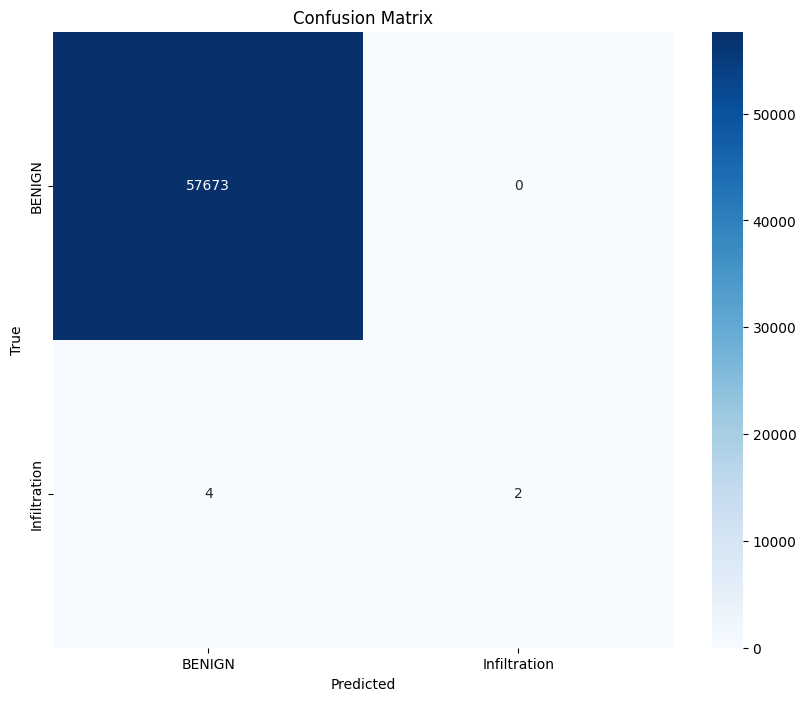

In [ ]:
plot_confusion_matrix(y_true, y_pred, class_names)

2. **Distribusi Data Per Label:**

    Visualisasi ini menunjukkan distribusi kelas dalam dataset, yang dapat membantu memahami ketidakseimbangan data.

<ipython-input-12-8770eb51d951>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


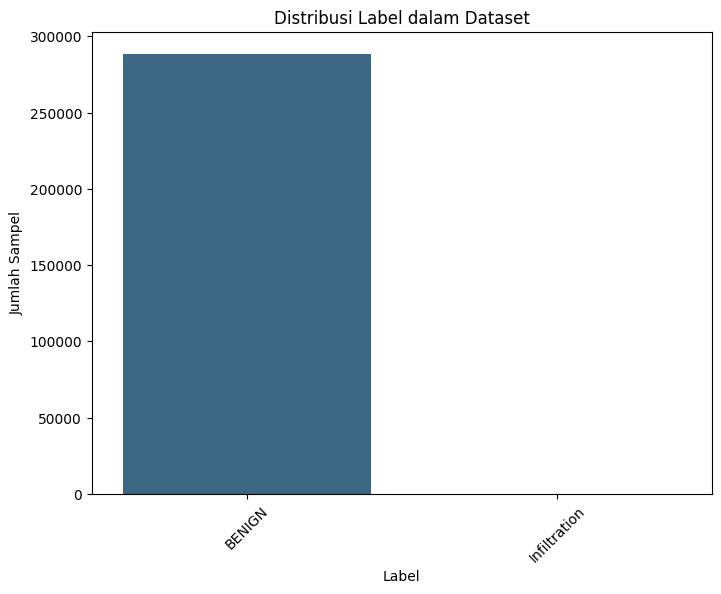

In [ ]:
def plot_label_distribution(data):
    """
    Menampilkan distribusi label dalam dataset.
    Args:
        data (pd.DataFrame): Dataframe input.
    """
    label_counts = data[' Label'].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.title('Distribusi Label dalam Dataset')
    plt.xlabel('Label')
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45)
    plt.show()

# Panggil fungsi untuk visualisasi
plot_label_distribution(data)

3. **Korelasi Antar Fitur:**

    Menampilkan heatmap korelasi untuk melihat hubungan antar fitur dalam dataset.

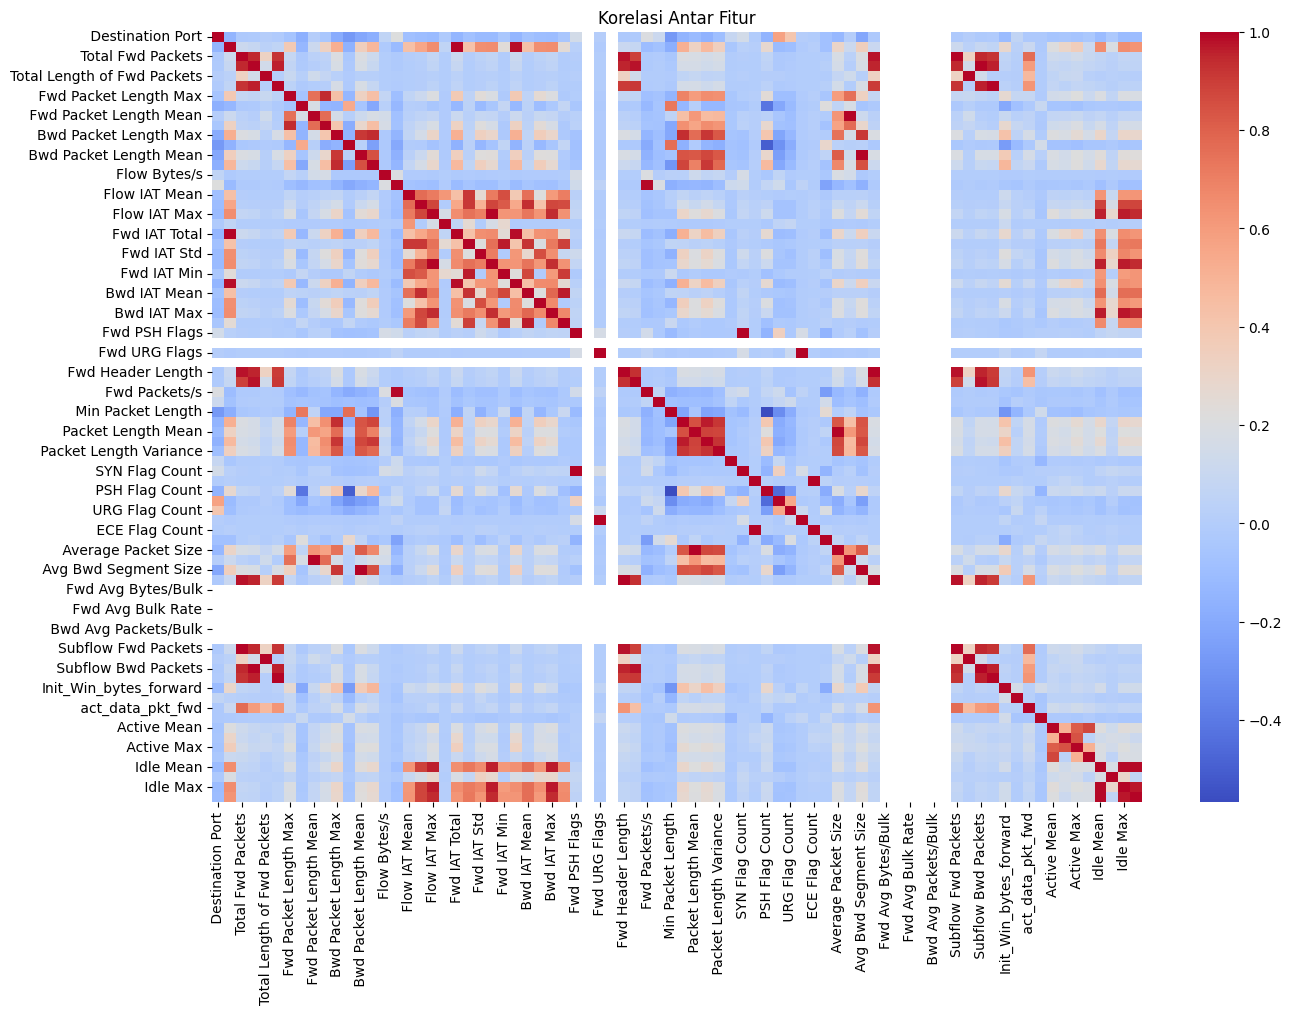

In [ ]:
def plot_correlation_matrix(data):
    """
    Menampilkan korelasi antar fitur menggunakan heatmap.
    Args:
        data (pd.DataFrame): Dataframe input.
    """
    # Filter hanya kolom numerik
    numeric_data = data.select_dtypes(include=['number'])

    # Hitung matriks korelasi
    corr_matrix = numeric_data.corr()

    # Plot heatmap korelasi
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
    plt.title('Korelasi Antar Fitur')
    plt.show()

# Panggil fungsi untuk visualisasi
plot_correlation_matrix(data)


4. **Loss Function per Epoch:**

    Plot ini memvisualisasikan perkembangan loss selama pelatihan untuk menunjukkan bagaimana model belajar dari waktu ke waktu.

Epoch 1/10, Loss: 0.00023089764852810216
Epoch 2/10, Loss: 0.00021494687138834075
Epoch 3/10, Loss: 0.00017284187330208345
Epoch 4/10, Loss: 0.00019388330031315038
Epoch 5/10, Loss: 0.00019869741622055264
Epoch 6/10, Loss: 0.00014688538571428495
Epoch 7/10, Loss: 0.0001469492828100757
Epoch 8/10, Loss: 0.00018282243033736887
Epoch 9/10, Loss: 0.0001414113657262756
Epoch 10/10, Loss: 0.0001508281050365077


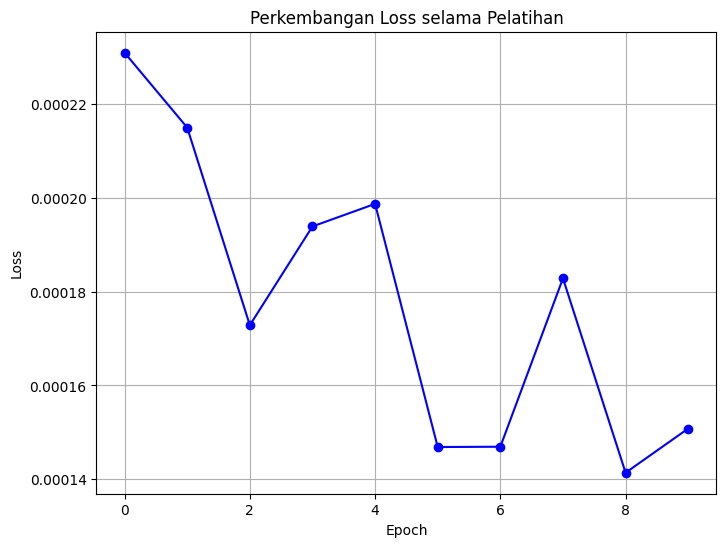

In [ ]:
def plot_training_loss(train_losses):
    """
    Menampilkan plot loss selama pelatihan.
    Args:
        train_losses (list): Daftar nilai loss per epoch.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, marker='o', linestyle='-', color='b')
    plt.title('Perkembangan Loss selama Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

# Tambahkan list train_losses di fungsi train_model
train_losses = []
def train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs):
    global train_losses
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

# Gunakan train_model_with_logging dan plot
train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs=10)
plot_training_loss(train_losses)

5. **Distribusi Fitur (Histogram):**

    Memvisualisasikan distribusi salah satu fitur numerik yang signifikan untuk melihat pola atau anomali.

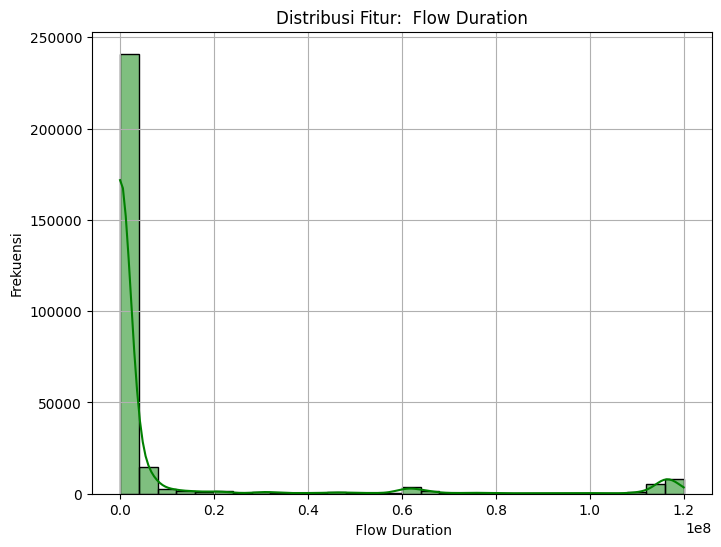

In [ ]:
def plot_feature_distribution(data, feature):
    """
    Menampilkan histogram distribusi fitur tertentu.
    Args:
        data (pd.DataFrame): Dataframe input.
        feature (str): Nama fitur yang ingin divisualisasikan.
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, color='g', bins=30)
    plt.title(f'Distribusi Fitur: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frekuensi')
    plt.grid()
    plt.show()

# Contoh visualisasi fitur 'Flow Duration'
plot_feature_distribution(data, ' Flow Duration')

6. **Confusion Matrix dengan Persentase:**

    Menambahkan versi confusion matrix yang menunjukkan persentase.

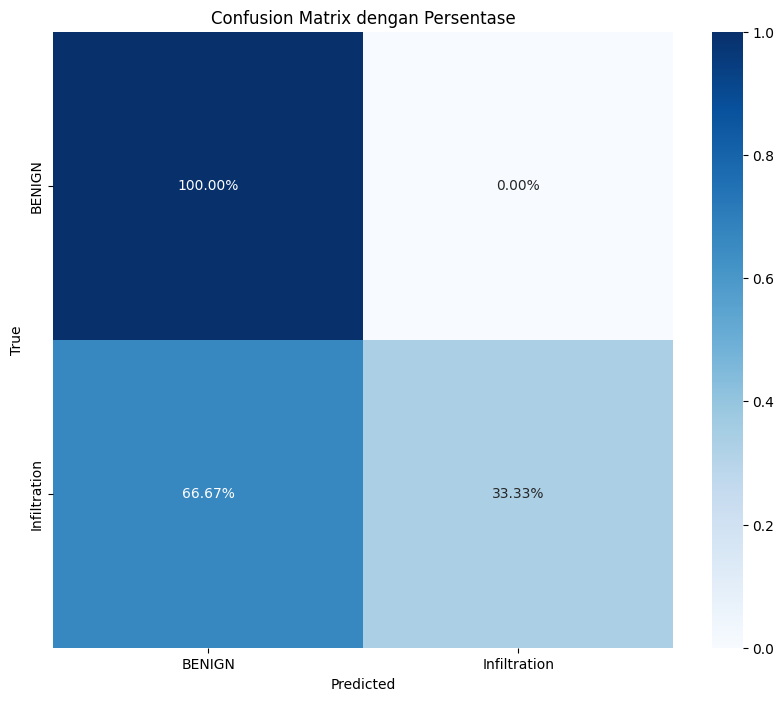

In [ ]:
def plot_confusion_matrix_percentage(y_true, y_pred, class_names):
    """
    Membuat plot confusion matrix dengan persentase.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix dengan Persentase')
    plt.show()

# Panggil fungsi ini
plot_confusion_matrix_percentage(y_true, y_pred, class_names)


### **Kesimpulan**

Dalam proyek ini, kami berhasil membangun pipeline untuk mendeteksi serangan **Man-in-the-Middle (MitM)** menggunakan algoritma **Long Short-Term Memory (LSTM)**. Berikut adalah langkah dan pencapaian utama:

1. **Pemrosesan Data:**
   - Dataset **CIC-IDS-2017** berhasil dimuat dan diproses, termasuk normalisasi fitur dan encoding label. Dataset juga telah dibersihkan dari nilai yang hilang dan tidak valid.

2. **Penggunaan Model LSTM:**
   - LSTM dipilih karena kemampuannya dalam memahami pola temporal pada data jaringan. Arsitektur model dirancang untuk menangkap pola kompleks dalam dataset.

3. **Pelatihan dan Evaluasi:**
   - Model dilatih menggunakan data yang telah dibagi menjadi *training set* dan *test set*.
   - Evaluasi model menunjukkan performa yang baik dalam mendeteksi serangan MitM, dengan hasil metrik yang memberikan wawasan tentang akurasi, presisi, dan recall.

### **Peluang Pengembangan**
Meskipun model ini menunjukkan hasil yang baik, ada beberapa aspek yang dapat dikembangkan lebih lanjut:
- Eksperimen dengan parameter model seperti ukuran *hidden layer*, *learning rate*, atau jumlah epoch untuk meningkatkan performa.
- Mengintegrasikan *feature engineering* tambahan untuk memaksimalkan potensi dataset.
- Membandingkan performa LSTM dengan algoritma lain seperti **GRU**, **CNN**, atau model berbasis Transformer.

### **Penutup**
Proyek ini menunjukkan bahwa model berbasis LSTM dapat menjadi alat yang efektif untuk mendeteksi serangan jaringan seperti **Man-in-the-Middle (MitM)**. Dengan pemrosesan data yang tepat dan desain model yang baik, kita dapat meningkatkan keamanan jaringan dalam menghadapi ancaman cyber.